## Import Dependencies

In [126]:
# Import Dependencies for Data Processing
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.extra.rate_limiter import RateLimiter
import geopy.distance


# Import Dependencies for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import Dependencies for Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFE
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Define Functions

In [3]:
# Determine the number of bins
def determine_num_bins(data, method='sqrt'):
    """
    Determine the number of bins for multiple columns in a DataFrame using the square root rule, Sturges' formula, or the Freedman-Diaconis rule.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        method (str): The method to use for determining the number of bins. Possible values: 'sqrt', 'sturges', 'freedman-diaconis'.

    Returns:
        dict: A dictionary mapping column names to the number of bins determined by the specified method.
    """
    num_bins_dict = {}

    for column in data.columns:
        column_data = data[column]

        if method == 'sqrt':
            num_bins = int(np.sqrt(len(column_data)))
        elif method == 'sturges':
            num_bins = int(np.ceil(np.log2(len(column_data)) + 1))
        elif method == 'freedman-diaconis':
            unique_values = len(column_data.unique())
            iqr = np.percentile(column_data, 75) - np.percentile(column_data, 25)

            # Check if the IQR is zero or the number of unique values is less than or equal to 1
            if iqr == 0 or unique_values <= 1:
                num_bins = 1  # Set the number of bins to 1
            else:
                bin_width = 2 * iqr / np.power(unique_values, 1/3)
                num_bins = int(np.ceil((column_data.max() - column_data.min()) / bin_width))
        else:
            raise ValueError("Invalid method specified. Supported methods: 'sqrt', 'sturges', 'freedman-diaconis'.")

        num_bins_dict[column] = num_bins

    return num_bins_dict

In [4]:
# Define Function to get address using latitude and longitude
def get_address(row):
    geolocator = Nominatim(user_agent="my_app")  # Instantiate a geocoder

    latitude = row['lat']
    longitude = row['lon']
    geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)
    location = geocode((latitude, longitude))  # Reverse geocode the coordinates

    # Extract relevant address components
    address = location.raw['address']
    street = address.get('road', '')
    neighbourhood = address.get('neighbourhood', '')
    postcode = address.get('postcode', '')

    # Update the row with address components
    row['street'] = street
    row['neighbourhood'] = neighbourhood
    row['postcode'] = postcode

    return row

In [5]:
# Define Function to Remove Outliers
def remove_outliers(df, column_name, threshold=3):
    z_scores = (df[column_name] - df[column_name].mean()) / df[column_name].std()  # Calculate z-scores
    filtered_df = df[abs(z_scores) <= threshold]  # Filter rows based on the threshold

    return filtered_df

In [6]:
def handle_rare_categories(data, columns, threshold=0.05, replacement='others'):
    """
    Perform rare category handling by grouping rare categories in specified columns as "others".

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        columns (list): A list of column names to process.
        threshold (float): The threshold below which a category is considered rare (default: 0.05).
        replacement (str): The replacement value for rare categories (default: "others").

    Returns:
        pd.DataFrame: The modified DataFrame with rare categories replaced.
    """
    modified_data = data.copy()  # Create a copy of the original DataFrame

    for column in columns:
        value_counts = data[column].value_counts(normalize=True)  # Calculate the normalized value counts

        # Identify rare categories below the threshold
        rare_categories = value_counts[value_counts < threshold].index

        # Replace rare categories with the specified replacement value
        modified_data.loc[modified_data[column].isin(rare_categories), column] = replacement

    return modified_data

In [67]:
def create_violin_charts(data, columns):
    deep_palette = sns.color_palette("deep")
    
    for column in columns:
        sns.violinplot(x=column, y='price_square_meter', data=data, palette=deep_palette)
        plt.title(f'Price per Square Meter by {column.capitalize()}')
        plt.show()

In [80]:
def create_scatter_plots(data, columns):
    for column in columns:
        # Scatter plot
        plt.scatter(data[column], data['price_square_meter'], alpha=0.5)
        
        # Linear regression
        sns.regplot(x=column, y='price_square_meter', data=data, scatter=False, color='r')
        
        plt.xlabel(column.capitalize())
        plt.ylabel('Price per Square Meter')
        plt.title(f'Correlation: {column.capitalize()} vs. Price per Square Meter')
        plt.show()

In [108]:
def perform_feature_selection(X, y, num_features):
    selector = SelectKBest(score_func=mutual_info_regression, k=num_features)
    selector.fit(X, y)
    feature_scores = selector.scores_
    feature_names = X.columns
    feature_scores_names = list(zip(feature_names, feature_scores))
    feature_scores_names.sort(key=lambda x: x[1], reverse=True)
    selected_features = [feature[0] for feature in feature_scores_names[:num_features]]
    return selected_features

# Análisis Precio por Metro Cuadrado de Vivienda

## Análisis Exploratorio y Data Cleaning

### Análisis Exploratorio

#### Importar Data

In [6]:
# Declare file path variable
file_path = 'resources/reto_precios.csv'

# Read data
housing_df = pd.read_csv(file_path)
housing_df.head()

,main_name,subtitle,link,location,price,attributes,timestamp,id,address,since,...,apartments_per_floor,disposition,parking_lots,floor_situated,orientation,num_bedrooms,department_type,m2,final_price,price_square_meter
0,Departamento - Roma Norte,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Sinaloa 20 , Roma Sur, Roma Sur, Cuauhtémoc, D...",9000000 pesos,"127 m² construidos,2 recs.",2022-03-29,1,"Sinaloa 20 , Roma Sur",Publicado hace 5 días,...,NaN,Contrafrente,2,NaN,NaN,2.0,NaN,127.0,9000000.0,70866.141732
1,Preventa Exclusiva · Terraloza Roma Norte ·,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Tonala, Roma Norte, Cuauhtémoc, Distrito Federal",4264000 pesos,"54 m² construidos,1 rec.",2022-03-29,2,Tonala,Publicado hace 7 días,...,NaN,NaN,1,NaN,NaN,1.0,NaN,54.0,4264000.0,78962.962963
2,Townhouse Único En La Roma Sur,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...",8093500 pesos,"163 m² construidos,3 recs.",2022-03-29,3,"Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...",Publicado hace 4 días,...,NaN,NaN,2,NaN,NaN,3.0,NaN,163.0,8093500.0,49653.374233
3,"Departamento En Roma Sur, Cuauhtémoc Con 2 Rec...",Departamento en venta,https://departamento.metroscubicos.com/MLM-132...,"Linares, Roma Sur, Cuauhtémoc, Distrito Federal",4000000 pesos,"93 m² construidos,2 recs.",2022-03-29,4,Linares,Publicado hace 5 meses por {action},...,NaN,NaN,1,NaN,Oeste,2.0,Loft,93.0,4000000.0,43010.752688
4,Últimos Deptos En Preventa En Roma Norte,Departamento en venta,https://departamento.metroscubicos.com/MLM-137...,"Frontera, Roma Norte, Cuauhtémoc, Distrito Fed...",6732700 pesos,"103 m² construidos,2 recs.",2022-03-29,5,Frontera,Publicado hace 52 días,...,NaN,NaN,1,NaN,NaN,2.0,NaN,103.0,6732700.0,65366.019417


#### Estructura

In [7]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   main_name             981 non-null    object 
 1   subtitle              981 non-null    object 
 2   link                  981 non-null    object 
 3   location              981 non-null    object 
 4   price                 981 non-null    object 
 5   attributes            981 non-null    object 
 6   timestamp             981 non-null    object 
 7   id                    981 non-null    int64  
 8   address               702 non-null    object 
 9   since                 981 non-null    object 
 10  description           981 non-null    object 
 11  vendor                981 non-null    object 
 12  lat                   981 non-null    float64
 13  lon                   981 non-null    float64
 14  price_mod             981 non-null    float64
 15  price_currency        9

By analyzing our dataset shape we can see that we have one categorical value that will be our label, price_square_meter. The columns we have to work with can be divided into the following categories:
- Property General Information
    - **main_name** : This has the name of the ad for every row (publication).
    - **subtitle** : Type of property, in this case, all the rows have the same type, "Departamento en venta". We can delete this column, given that it doesn't provide any useful information to categorize the properties.
    - **link** : This column has a direct link to the property posted. Further down the path, we can try to gather more information scrapping https://departamento.metroscubicos.com/
    - **location** : This column has a general description of the location of the apartment, we can try to use regular expression to separate the data in City, Township, Neighbourhood and Street
    - **price** : This column has the price of the property with the currency used. Regular expressions could also be useful to separate and convert currencies to a unified format.
    - **id** : index row.
    - **description** : General description of the property.
    - **vendor** : Real state agency posting the property.
    - **amenities** : Number of amenities of the property.
    - **bathrooms** : Number of bathrooms the property has.
    - **cellars**
    - **num_floors** : How many stories the property is.
    - **monthly_fee** : We will assume this column is, in case the property is also on rent. 
    - **apartments_per_floor**
    - **disposition** : Orientation of the apartment.
    - **parking_lots** : How many parking spaces the apartment provides.
    - **floor_situated** : On which floor the property is situated.
    - **orientation** : Which way the apartment is heading to.
    - **num_bedrooms** : Given that we have this columns, its not neccesary to use regex to extract it from the attributes column.
    - **department_type** : Irrelevant given that the only possible values are either Loft or blank.
    

- Property Location
    - **address** : This has the same general information as the location column but it's a little bit more inconsistent.
    - **lat** : Property geolocalization latitude. This could prove useful in the case that the other location columns are too inconsistent.
    - **lon** : Property geolocalization longitude. Same as the previous column, could be use paired with an API to extract an exact location.
    
    
- Property Size
    - **attributes** : This column is structured as Square Meters Built, # Bedrooms. Given that we already have separate columns for this two attributes it is not neccesary to use it.
    - **m2** : square meters of the property which means we don't have to use regex on attributes to extract this either.

- Date of Publication
    - **timestamp**: This column can be deleted given that all the rows have the same date. It's assumed that this is the date of the web scrapping done to the website.
    - **since**: Days of publication. How long does the property has been posted.
    - **since_period** : paired with the next column it is used to determined how long the property has been posted.
    - **since_value** : number of periods the publication has been posted.
    - **days_on_site** : easier to use, exact days that the property has been posted on the site.
    - **age_in_years** : Irrelevant given that the value of every row is 0.
    
    
    
- Property Value
    - **price_mod** : This is extracted from the price column, separation the amount from the currency.
    - **price_currency** : Currency used in the property price.
    - **final_price** : This a unified column taken from the two columns above which means we don't have to use those either.
    - **price_square_meter** : Price per square meter. Our target variable.

### Data Cleaning

First, let's delete the columns that we already identify as irrelevant. 
- main_name
- subtitle
- link (This could be use for web scrapping later)
- price
- id
- department_type
- attributes
- timestamp
- since
- since_period
- since_value
- age_in_years
- price_mod
- price_currency

In [8]:
# Declare columns to delete
columns_delete = ['main_name','subtitle','link','price','id'
                  ,'department_type','attributes','timestamp'
                  ,'since','since_period','since_value','age_in_years'
                  , 'price_mod','price_currency']

# Delete Columns in place
housing_df.drop(columns_delete, axis=1, inplace=True)

#### Manejo de Valores Faltantes

In [9]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   location              981 non-null    object 
 1   address               702 non-null    object 
 2   description           981 non-null    object 
 3   vendor                981 non-null    object 
 4   lat                   981 non-null    float64
 5   lon                   981 non-null    float64
 6   days_on_site          981 non-null    float64
 7   amenities             504 non-null    float64
 8   bathrooms             981 non-null    float64
 9   cellars               52 non-null     float64
 10  num_floors            84 non-null     float64
 11  monthly_fee           128 non-null    object 
 12  apartments_per_floor  15 non-null     float64
 13  disposition           20 non-null     object 
 14  parking_lots          981 non-null    int64  
 15  floor_situated        2

From the shape of our DataFrame we can see that there are multiple columns almost no data which we can simply drop:
- orientation
- floor_situated
- disposition
- cellars
- num_floors
- apartments_per_floor
- monthly_fee

We also have two columns where we need to handle the missing values deciding which technique to use:
- address
- amenities

In [10]:
# Drop the columns with almost no data
columns_nodata = ['orientation','floor_situated','disposition','cellars'
                  ,'num_floors','apartments_per_floor','monthly_fee']

# Drop the columns in place
housing_df.drop(columns_nodata, axis=1, inplace=True)

In [11]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   location            981 non-null    object 
 1   address             702 non-null    object 
 2   description         981 non-null    object 
 3   vendor              981 non-null    object 
 4   lat                 981 non-null    float64
 5   lon                 981 non-null    float64
 6   days_on_site        981 non-null    float64
 7   amenities           504 non-null    float64
 8   bathrooms           981 non-null    float64
 9   parking_lots        981 non-null    int64  
 10  num_bedrooms        981 non-null    float64
 11  m2                  981 non-null    float64
 12  final_price         981 non-null    float64
 13  price_square_meter  981 non-null    float64
dtypes: float64(9), int64(1), object(4)
memory usage: 107.4+ KB


The most covenient way to still use our amenities column without being misleading in this case would be to replace the null values with the average.

In [12]:
# Calculate the average value
average_amenities = housing_df['amenities'].mean()

# Replace null values with the average
housing_df['amenities'].fillna(average_amenities, inplace=True)

On this particular case, considering that this is something we will need to do once, and given the size of the Data, instead of opting for the common option of using regular expressions on the columns for address, we are going to use geopy library to extract:
- Street
- Suburb
- Postcode

And use those variables as our location information for the property. We have to be aware that this won't be a sustainable option once our dataset starts to get bigger and the most cost and time efficient way will be to extract from regular expressions our neccesary information.

The way we are going to tackle this is by using the latitude and longitude provided and previously define a function to parse our dataframe.

We will be losing the information on Township, but this is easily replaceable by extracting the postcode of the address.

In [21]:
# Apply function, get Street, Township and Suburb
updated_rows = housing_df.apply(lambda row: get_address(row), axis=1)

# Merge the updated rows with the original DataFrame
housing_df = pd.concat([housing_df, updated_rows[['street', 'neighbourhood', 'postcode']]], axis=1)

In [38]:
housing_df.to_csv('resources/reto_precios_direccion.csv')

In [28]:
housing_df = pd.read_csv('resources/reto_precios_direccion.csv')

One of the most predominant topics of discussion whenever Real Estate and Property Value comes up is gentrification. In order to boost the predictive capabilities of our possible model and be able to identify tendencies. Let's introduce two features with the possibility to broaden them down the road.

Following the logic behind gentrification, being the recent movement seen from citizens of countries with higher purchasing power than the average we see here in Mexico, mainly in Mexico City moving into the city and increasing the overall market value of real estate properties.

There are several characteristics that propitiate this movement. One of them being globalization, the fact that the western culture has been expanding more and more to countries that used to have a way of living and culture very different than the one we see in the US (being the leading culture were "westernization" comes from. It's easier now for those US citizen to move to other countries to improve their lifestyle and have access to the same commodities.

Two main examples of this are:
- Starbucks
- Airbnb

Given that Starbucks is sometimes seen as a colonization agent, ambassador of US culture. Having access to this franchise let's them have the same commodities on a different country, summing it up, a clear representation of their neccesities being met in the area.

The second one, Airbnb, is one of the best ways of studying changes on the market of properties. We may be able to identify trends quicker on the Airbnb market rather than waiting for them to reflect on rent prices or overall value of real estate.

In [29]:
# Import datasets
starbucks_df = pd.read_csv('resources/MexicoCityStarbucks.csv')
airbnb_df = pd.read_csv('resources/Airbnb.csv')

In [30]:
# Create columns to store number of Airbnb and Starbucks nearby
housing_df['no_airbnb'] = ''
housing_df['no_starbucks'] = ''
housing_df['airbnb_mean_price'] = ''

# Declare for loop to iterate over every row of catastro_df to compare distance radius
for df_index, row in housing_df.iterrows():
    
    # Declare counter variable to hold number of Airbnbs and Starbucks nearby
    no_airbnb = 0
    no_starbucks = 0
    airbnb_price = 0
    holder_price = 0
    mean_price = 0
    
    # Get Latitude and Longitude of the row
    lat_house = row['lat']
    lng_house = row['lon']
    street = row['street']
    # Pair coordinates
    housing_loc = (lat_house,lng_house)
    
    # With every catastro_df row, iterate and compare distances between each row of Airbnbs
    for bnb_index, row in airbnb_df.iterrows():
        
        # Get Latitude and Longitude of the row
        lat_bnb = row['latitude']
        lng_bnb = row['longitude']
        # Pair coordinates
        airbnb_loc = (lat_bnb,lng_bnb)
        
        # Using geopy.distance module, compare both coordinate to determine distance between them
        distancia = geopy.distance.geodesic(housing_loc, airbnb_loc).m
        
        # Create conditional to add 1 to the counter if Airbnb is within 500m of Catastro_df row location
        if distancia < 200:
            airbnb_price = row['price']
            holder_price = airbnb_price + holder_price
            no_airbnb = no_airbnb + 1
            
    # After parsing on every row, append number of airbnbs nearby
    housing_df.loc[df_index, 'no_airbnb'] = no_airbnb
    if no_airbnb > 0:
        mean_price = holder_price / no_airbnb
        housing_df.loc[df_index, 'airbnb_mean_price'] = mean_price
    
    # With every catastro_df row, iterate and compare distances between each row of Starbucks
    for starbucks_index, row in starbucks_df.iterrows():
        try: 
            # Get Latitude and Longitude of the row
            lat_starbucks = row['Latitude']
            lng_starbucks = row['Longitude']
        
            # Pair Coordinates
            starbucks_loc = (lat_starbucks,lng_starbucks)
        
            # Using geopy.distance module, compare both coordinate to determine distance between them
            distancia_starbucks = geopy.distance.geodesic(housing_loc, starbucks_loc).m
        
            # Create conditional to add 1 to the counter if Starbucks is within 500m of Catastro_df row location
            if distancia_starbucks < 800:
                no_starbucks = no_starbucks + 1
                
        except(ValueError):
            print('Value Error for', row['Street Address'])
    
    # After parsing on every row, append number of Starbucks nearby
    housing_df.loc[df_index, 'no_starbucks'] = no_starbucks
    print('-----------------------------------')
    print(f'Row #{df_index} Street: {street}')
    print(f'{no_airbnb} Airbnbs found')
    print(f'Airbnb average cost: ${mean_price:.0f}')
    print(f'{no_starbucks} Starbucks found')
    print('-----------------------------------')

-----------------------------------
Row #0 Street: Calle Sinaloa
114 Airbnbs found
Airbnb average cost: $1904
3 Starbucks found
-----------------------------------
-----------------------------------
Row #1 Street: Avenida Insurgentes Sur
101 Airbnbs found
Airbnb average cost: $1891
3 Starbucks found
-----------------------------------
-----------------------------------
Row #2 Street: Calle Tepeji
78 Airbnbs found
Airbnb average cost: $1125
2 Starbucks found
-----------------------------------
-----------------------------------
Row #3 Street: Calle Linares
84 Airbnbs found
Airbnb average cost: $767
6 Starbucks found
-----------------------------------
-----------------------------------
Row #4 Street: Calle Frontera
125 Airbnbs found
Airbnb average cost: $1186
2 Starbucks found
-----------------------------------
-----------------------------------
Row #5 Street: Chilpancingo
73 Airbnbs found
Airbnb average cost: $1061
7 Starbucks found
-----------------------------------
-----------

-----------------------------------
Row #50 Street: Calle Colima
79 Airbnbs found
Airbnb average cost: $2217
3 Starbucks found
-----------------------------------
-----------------------------------
Row #51 Street: Calle Frontera
125 Airbnbs found
Airbnb average cost: $1186
2 Starbucks found
-----------------------------------
-----------------------------------
Row #52 Street: Calle Colima
79 Airbnbs found
Airbnb average cost: $2217
3 Starbucks found
-----------------------------------
-----------------------------------
Row #53 Street: Calle Alejandría
0 Airbnbs found
Airbnb average cost: $0
0 Starbucks found
-----------------------------------
-----------------------------------
Row #54 Street: Calle Quintana Roo
63 Airbnbs found
Airbnb average cost: $1240
13 Starbucks found
-----------------------------------
-----------------------------------
Row #55 Street: Calle Quintana Roo
74 Airbnbs found
Airbnb average cost: $810
6 Starbucks found
-----------------------------------
-------

-----------------------------------
Row #100 Street: Calle Colima
79 Airbnbs found
Airbnb average cost: $2217
3 Starbucks found
-----------------------------------
-----------------------------------
Row #101 Street: Calle Colima
79 Airbnbs found
Airbnb average cost: $2217
3 Starbucks found
-----------------------------------
-----------------------------------
Row #102 Street: Calle Colima
79 Airbnbs found
Airbnb average cost: $2217
3 Starbucks found
-----------------------------------
-----------------------------------
Row #103 Street: Calle Colima
79 Airbnbs found
Airbnb average cost: $2217
3 Starbucks found
-----------------------------------
-----------------------------------
Row #104 Street: Calle Colima
79 Airbnbs found
Airbnb average cost: $2217
3 Starbucks found
-----------------------------------
-----------------------------------
Row #105 Street: Calle Quintana Roo
63 Airbnbs found
Airbnb average cost: $1240
13 Starbucks found
-----------------------------------
---------

-----------------------------------
Row #149 Street: Calle Michoacán
131 Airbnbs found
Airbnb average cost: $2114
6 Starbucks found
-----------------------------------
-----------------------------------
Row #150 Street: Calle Tonalá
105 Airbnbs found
Airbnb average cost: $1422
4 Starbucks found
-----------------------------------
-----------------------------------
Row #151 Street: Calle de la Constitución
30 Airbnbs found
Airbnb average cost: $936
1 Starbucks found
-----------------------------------
-----------------------------------
Row #152 Street: Avenida Querétaro
137 Airbnbs found
Airbnb average cost: $1702
8 Starbucks found
-----------------------------------
-----------------------------------
Row #153 Street: Avenida Querétaro
137 Airbnbs found
Airbnb average cost: $1702
8 Starbucks found
-----------------------------------
-----------------------------------
Row #154 Street: Avenida Chapultepec
24 Airbnbs found
Airbnb average cost: $1346
3 Starbucks found
-----------------

-----------------------------------
Row #198 Street: Avenida Monterrey
58 Airbnbs found
Airbnb average cost: $1025
2 Starbucks found
-----------------------------------
-----------------------------------
Row #199 Street: Avenida Monterrey
58 Airbnbs found
Airbnb average cost: $1025
2 Starbucks found
-----------------------------------
-----------------------------------
Row #200 Street: Calle Quintana Roo
87 Airbnbs found
Airbnb average cost: $730
6 Starbucks found
-----------------------------------
-----------------------------------
Row #201 Street: Avenida Monterrey
58 Airbnbs found
Airbnb average cost: $1025
2 Starbucks found
-----------------------------------
-----------------------------------
Row #202 Street: Calle San Luis Potosí
75 Airbnbs found
Airbnb average cost: $1151
4 Starbucks found
-----------------------------------
-----------------------------------
Row #203 Street: Avenida Querétaro
141 Airbnbs found
Airbnb average cost: $1682
8 Starbucks found
-----------------

-----------------------------------
Row #247 Street: Calle Coahuila
114 Airbnbs found
Airbnb average cost: $1298
8 Starbucks found
-----------------------------------
-----------------------------------
Row #248 Street: Calle Coahuila
114 Airbnbs found
Airbnb average cost: $1298
8 Starbucks found
-----------------------------------
-----------------------------------
Row #249 Street: Calle Coahuila
114 Airbnbs found
Airbnb average cost: $1298
8 Starbucks found
-----------------------------------
-----------------------------------
Row #250 Street: Calle Coahuila
114 Airbnbs found
Airbnb average cost: $1298
8 Starbucks found
-----------------------------------
-----------------------------------
Row #251 Street: Calle Coahuila
114 Airbnbs found
Airbnb average cost: $1298
8 Starbucks found
-----------------------------------
-----------------------------------
Row #252 Street: Calle Coahuila
114 Airbnbs found
Airbnb average cost: $1298
8 Starbucks found
----------------------------------

-----------------------------------
Row #296 Street: Calle Coahuila
114 Airbnbs found
Airbnb average cost: $1298
8 Starbucks found
-----------------------------------
-----------------------------------
Row #297 Street: Calle Coahuila
114 Airbnbs found
Airbnb average cost: $1298
8 Starbucks found
-----------------------------------
-----------------------------------
Row #298 Street: Calle Coahuila
114 Airbnbs found
Airbnb average cost: $1298
8 Starbucks found
-----------------------------------
-----------------------------------
Row #299 Street: Calle Coahuila
114 Airbnbs found
Airbnb average cost: $1298
8 Starbucks found
-----------------------------------
-----------------------------------
Row #300 Street: Calle Coahuila
114 Airbnbs found
Airbnb average cost: $1298
8 Starbucks found
-----------------------------------
-----------------------------------
Row #301 Street: Calle Coahuila
114 Airbnbs found
Airbnb average cost: $1298
8 Starbucks found
----------------------------------

-----------------------------------
Row #345 Street: Avenida Eugenio Garza Sada
0 Airbnbs found
Airbnb average cost: $0
0 Starbucks found
-----------------------------------
-----------------------------------
Row #346 Street: Calle Tabasco
76 Airbnbs found
Airbnb average cost: $2018
3 Starbucks found
-----------------------------------
-----------------------------------
Row #347 Street: Calle Coahuila
114 Airbnbs found
Airbnb average cost: $1298
8 Starbucks found
-----------------------------------
-----------------------------------
Row #348 Street: Calle Jalapa
104 Airbnbs found
Airbnb average cost: $1676
4 Starbucks found
-----------------------------------
-----------------------------------
Row #349 Street: Calle Quintana Roo
63 Airbnbs found
Airbnb average cost: $1240
13 Starbucks found
-----------------------------------
-----------------------------------
Row #350 Street: Tehuantepec
52 Airbnbs found
Airbnb average cost: $1186
7 Starbucks found
-------------------------------

-----------------------------------
Row #394 Street: Calle Monclova
63 Airbnbs found
Airbnb average cost: $898
12 Starbucks found
-----------------------------------
-----------------------------------
Row #395 Street: Calle Monclova
63 Airbnbs found
Airbnb average cost: $898
12 Starbucks found
-----------------------------------
-----------------------------------
Row #396 Street: Calle Monclova
63 Airbnbs found
Airbnb average cost: $898
12 Starbucks found
-----------------------------------
-----------------------------------
Row #397 Street: Calle Bajío
66 Airbnbs found
Airbnb average cost: $1082
5 Starbucks found
-----------------------------------
-----------------------------------
Row #398 Street: Calle Puebla
166 Airbnbs found
Airbnb average cost: $1466
1 Starbucks found
-----------------------------------
-----------------------------------
Row #399 Street: Calle Monclova
63 Airbnbs found
Airbnb average cost: $898
12 Starbucks found
-----------------------------------
--------

-----------------------------------
Row #444 Street: Avenida Monterrey
58 Airbnbs found
Airbnb average cost: $1025
2 Starbucks found
-----------------------------------
-----------------------------------
Row #445 Street: Calle Bajío
56 Airbnbs found
Airbnb average cost: $1046
1 Starbucks found
-----------------------------------
-----------------------------------
Row #446 Street: Calle Jalapa
104 Airbnbs found
Airbnb average cost: $1876
2 Starbucks found
-----------------------------------
-----------------------------------
Row #447 Street: Privada de la Constitución
30 Airbnbs found
Airbnb average cost: $919
1 Starbucks found
-----------------------------------
-----------------------------------
Row #448 Street: Calle Quintana Roo
51 Airbnbs found
Airbnb average cost: $1186
7 Starbucks found
-----------------------------------
-----------------------------------
Row #449 Street: Tehuantepec
52 Airbnbs found
Airbnb average cost: $1186
7 Starbucks found
-----------------------------

-----------------------------------
Row #493 Street: Calle Córdoba
139 Airbnbs found
Airbnb average cost: $1644
4 Starbucks found
-----------------------------------
-----------------------------------
Row #494 Street: Calle Quintana Roo
63 Airbnbs found
Airbnb average cost: $1240
13 Starbucks found
-----------------------------------
-----------------------------------
Row #495 Street: Calle Quintana Roo
63 Airbnbs found
Airbnb average cost: $1240
13 Starbucks found
-----------------------------------
-----------------------------------
Row #496 Street: Calle Quintana Roo
63 Airbnbs found
Airbnb average cost: $1240
13 Starbucks found
-----------------------------------
-----------------------------------
Row #497 Street: Calle Colima
79 Airbnbs found
Airbnb average cost: $2217
3 Starbucks found
-----------------------------------
-----------------------------------
Row #498 Street: Calle Quintana Roo
63 Airbnbs found
Airbnb average cost: $1240
13 Starbucks found
----------------------

-----------------------------------
Row #542 Street: Calle Puebla
126 Airbnbs found
Airbnb average cost: $1491
1 Starbucks found
-----------------------------------
-----------------------------------
Row #543 Street: Calle Puebla
126 Airbnbs found
Airbnb average cost: $1491
1 Starbucks found
-----------------------------------
-----------------------------------
Row #544 Street: Calle Puebla
126 Airbnbs found
Airbnb average cost: $1491
1 Starbucks found
-----------------------------------
-----------------------------------
Row #545 Street: Medellín
74 Airbnbs found
Airbnb average cost: $1086
8 Starbucks found
-----------------------------------
-----------------------------------
Row #546 Street: Calle Bajío
75 Airbnbs found
Airbnb average cost: $1064
7 Starbucks found
-----------------------------------
-----------------------------------
Row #547 Street: Calle Quintana Roo
87 Airbnbs found
Airbnb average cost: $730
6 Starbucks found
-----------------------------------
-------------

-----------------------------------
Row #592 Street: Calle Linares
107 Airbnbs found
Airbnb average cost: $926
6 Starbucks found
-----------------------------------
-----------------------------------
Row #593 Street: Calle Colima
79 Airbnbs found
Airbnb average cost: $2217
3 Starbucks found
-----------------------------------
-----------------------------------
Row #594 Street: Calle Tonalá
59 Airbnbs found
Airbnb average cost: $1192
2 Starbucks found
-----------------------------------
-----------------------------------
Row #595 Street: Calle Colima
79 Airbnbs found
Airbnb average cost: $2217
3 Starbucks found
-----------------------------------
-----------------------------------
Row #596 Street: Calle Quintana Roo
63 Airbnbs found
Airbnb average cost: $1240
13 Starbucks found
-----------------------------------
-----------------------------------
Row #597 Street: Calle Tabasco
76 Airbnbs found
Airbnb average cost: $2018
3 Starbucks found
-----------------------------------
-------

-----------------------------------
Row #642 Street: Calle Coahuila
77 Airbnbs found
Airbnb average cost: $1202
2 Starbucks found
-----------------------------------
-----------------------------------
Row #643 Street: Calle Bajío
67 Airbnbs found
Airbnb average cost: $810
6 Starbucks found
-----------------------------------
-----------------------------------
Row #644 Street: Calle Tonalá
59 Airbnbs found
Airbnb average cost: $1192
2 Starbucks found
-----------------------------------
-----------------------------------
Row #645 Street: Calle Bajío
53 Airbnbs found
Airbnb average cost: $1074
1 Starbucks found
-----------------------------------
-----------------------------------
Row #646 Street: Calle Bajío
53 Airbnbs found
Airbnb average cost: $1074
1 Starbucks found
-----------------------------------
-----------------------------------
Row #647 Street: Calle Bajío
53 Airbnbs found
Airbnb average cost: $1074
1 Starbucks found
-----------------------------------
-------------------

-----------------------------------
Row #692 Street: Calle Quintana Roo
63 Airbnbs found
Airbnb average cost: $1240
13 Starbucks found
-----------------------------------
-----------------------------------
Row #693 Street: Calle Linares
88 Airbnbs found
Airbnb average cost: $834
6 Starbucks found
-----------------------------------
-----------------------------------
Row #694 Street: Calle Guanajuato
87 Airbnbs found
Airbnb average cost: $1558
4 Starbucks found
-----------------------------------
-----------------------------------
Row #695 Street: Calle Tabasco
76 Airbnbs found
Airbnb average cost: $2018
3 Starbucks found
-----------------------------------
-----------------------------------
Row #696 Street: Calle Colima
79 Airbnbs found
Airbnb average cost: $2217
3 Starbucks found
-----------------------------------
-----------------------------------
Row #697 Street: Calle Quintana Roo
63 Airbnbs found
Airbnb average cost: $1240
13 Starbucks found
---------------------------------

-----------------------------------
Row #742 Street: Calle Colima
79 Airbnbs found
Airbnb average cost: $2217
3 Starbucks found
-----------------------------------
-----------------------------------
Row #743 Street: Calle Colima
79 Airbnbs found
Airbnb average cost: $2217
3 Starbucks found
-----------------------------------
-----------------------------------
Row #744 Street: Calle Colima
79 Airbnbs found
Airbnb average cost: $2217
3 Starbucks found
-----------------------------------
-----------------------------------
Row #745 Street: Calle Coahuila
61 Airbnbs found
Airbnb average cost: $1593
2 Starbucks found
-----------------------------------
-----------------------------------
Row #746 Street: Calle Guanajuato
116 Airbnbs found
Airbnb average cost: $1795
3 Starbucks found
-----------------------------------
-----------------------------------
Row #747 Street: Calle Coahuila
73 Airbnbs found
Airbnb average cost: $1777
2 Starbucks found
-----------------------------------
-------

-----------------------------------
Row #792 Street: Avenida Insurgentes Sur
100 Airbnbs found
Airbnb average cost: $1780
3 Starbucks found
-----------------------------------
-----------------------------------
Row #793 Street: Calle Puebla
166 Airbnbs found
Airbnb average cost: $1466
1 Starbucks found
-----------------------------------
-----------------------------------
Row #794 Street: Calle Chiapas
54 Airbnbs found
Airbnb average cost: $1573
2 Starbucks found
-----------------------------------
-----------------------------------
Row #795 Street: Avenida Querétaro
93 Airbnbs found
Airbnb average cost: $1610
4 Starbucks found
-----------------------------------
-----------------------------------
Row #796 Street: Calle Tonalá
83 Airbnbs found
Airbnb average cost: $1193
4 Starbucks found
-----------------------------------
-----------------------------------
Row #797 Street: Calle Palestina
0 Airbnbs found
Airbnb average cost: $0
0 Starbucks found
----------------------------------

-----------------------------------
Row #842 Street: Calle Cozumel
100 Airbnbs found
Airbnb average cost: $1545
1 Starbucks found
-----------------------------------
-----------------------------------
Row #843 Street: Avenida Querétaro
138 Airbnbs found
Airbnb average cost: $1701
8 Starbucks found
-----------------------------------
-----------------------------------
Row #844 Street: Calle Tabasco
76 Airbnbs found
Airbnb average cost: $2018
3 Starbucks found
-----------------------------------
-----------------------------------
Row #845 Street: Calle Córdoba
122 Airbnbs found
Airbnb average cost: $1784
2 Starbucks found
-----------------------------------
-----------------------------------
Row #846 Street: Avenida Chapultepec
158 Airbnbs found
Airbnb average cost: $1458
1 Starbucks found
-----------------------------------
-----------------------------------
Row #847 Street: Calle Coahuila
94 Airbnbs found
Airbnb average cost: $1225
8 Starbucks found
-------------------------------

-----------------------------------
Row #891 Street: Calle Coahuila
73 Airbnbs found
Airbnb average cost: $1777
2 Starbucks found
-----------------------------------
-----------------------------------
Row #892 Street: Calle Colima
79 Airbnbs found
Airbnb average cost: $2217
3 Starbucks found
-----------------------------------
-----------------------------------
Row #893 Street: Avenida Querétaro
140 Airbnbs found
Airbnb average cost: $1675
8 Starbucks found
-----------------------------------
-----------------------------------
Row #894 Street: Calle Coahuila
94 Airbnbs found
Airbnb average cost: $1225
8 Starbucks found
-----------------------------------
-----------------------------------
Row #895 Street: Calle Linares
88 Airbnbs found
Airbnb average cost: $834
6 Starbucks found
-----------------------------------
-----------------------------------
Row #896 Street: Medellín
101 Airbnbs found
Airbnb average cost: $1335
8 Starbucks found
-----------------------------------
---------

-----------------------------------
Row #940 Street: Calle Tonalá
59 Airbnbs found
Airbnb average cost: $1192
2 Starbucks found
-----------------------------------
-----------------------------------
Row #941 Street: Calle Palestina
0 Airbnbs found
Airbnb average cost: $0
0 Starbucks found
-----------------------------------
-----------------------------------
Row #942 Street: Calle Palestina
0 Airbnbs found
Airbnb average cost: $0
0 Starbucks found
-----------------------------------
-----------------------------------
Row #943 Street: Calle Linares
88 Airbnbs found
Airbnb average cost: $834
6 Starbucks found
-----------------------------------
-----------------------------------
Row #944 Street: Calle Quintana Roo
63 Airbnbs found
Airbnb average cost: $1240
13 Starbucks found
-----------------------------------
-----------------------------------
Row #945 Street: Calle Paricutín
0 Airbnbs found
Airbnb average cost: $0
0 Starbucks found
-----------------------------------
------------

In [31]:
housing_df.head()

,location,address,description,vendor,lat,lon,days_on_site,amenities,bathrooms,parking_lots,num_bedrooms,m2,final_price,price_square_meter,street,neighbourhood,postcode,no_airbnb,no_starbucks,airbnb_mean_price
0,"Sinaloa 20 , Roma Sur, Roma Sur, Cuauhtémoc, D...","Sinaloa 20 , Roma Sur",Garden house con 2 habitaciones y dos baños c...,Investemx,19.421317,-99.164182,5,3.000000,2,2,2,127.0,9000000,70866.14173,Calle Sinaloa,Colonia Roma Norte,6700.0,114,3,1903.517544
1,"Tonala, Roma Norte, Cuauhtémoc, Distrito Federal",Tonala,Mezcla perfecta entre E S T I L O y C A L I D ...,Avitana,19.421029,-99.163541,7,2.000000,1,1,1,54.0,4264000,78962.96296,Avenida Insurgentes Sur,Colonia Roma Norte,6700.0,101,3,1891.445545
2,"Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...","Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...","Concepto único en Roma Sur, es un desarrollo d...",Ebranuncios,19.407814,-99.161872,4,4.081349,3,2,3,163.0,8093500,49653.37423,Calle Tepeji,Colonia Roma Sur,6760.0,78,2,1124.551282
3,"Linares, Roma Sur, Cuauhtémoc, Distrito Federal",Linares,[VEN] ID HM: 40395.En Houm hacemos todo más fá...,Houm,19.404992,-99.160243,150,2.000000,2,1,2,93.0,4000000,43010.75269,Calle Linares,Colonia Roma Sur,6760.0,84,6,767.416667
4,"Frontera, Roma Norte, Cuauhtémoc, Distrito Fed...",Frontera,"La mejor opción en Roma Norte, sólo 7 departam...",Contactobienesraicesgold,19.419693,-99.156036,52,4.000000,2,1,2,103.0,6732700,65366.01942,Calle Frontera,Colonia Juárez,6700.0,125,2,1185.632


In [32]:
housing_df.to_csv('resources/reto_precios_direccion_franchises.csv', index=False)

In [49]:
housing_df = pd.read_csv('resources/reto_precios_direccion_franchises.csv')

With this new columns, we can get rid of the **location** and **address** columns as well as **lat** and **lon**.

In [ ]:
# Calculate the average value
average_amenities = housing_df['no_airbnb'].mean()
average_amenities = housing_df['no_starbucks'].mean()
average_amenities = housing_df['airbnb_mean_price'].mean()

# Replace null values with the average
housing_df['no_airbnb'].fillna(average_amenities, inplace=True)
housing_df['no_starbucks'].fillna(average_amenities, inplace=True)
housing_df['airbnb_mean_price'].fillna(average_amenities, inplace=True)

housing_df[['no_airbnb'
            ,'no_starbucks'
            ,'airbnb_mean_price']] = housing_df[['no_airbnb'
                                                 ,'no_starbucks'
                                                 ,'airbnb_mean_price']].astype(int)

In [50]:
# Declare location columns to drop
columns_location = ['location','address','lat','lon']

# Drop the columns in place
housing_df.drop(columns_location, axis=1, inplace=True)

#### Eliminar Duplicados

In [51]:
housing_df.drop_duplicates(inplace=True)

housing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 963 entries, 0 to 980
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   description         963 non-null    object 
 1   vendor              963 non-null    object 
 2   days_on_site        963 non-null    int64  
 3   amenities           963 non-null    float64
 4   bathrooms           963 non-null    int64  
 5   parking_lots        963 non-null    int64  
 6   num_bedrooms        963 non-null    int64  
 7   m2                  963 non-null    float64
 8   final_price         963 non-null    int64  
 9   price_square_meter  963 non-null    float64
 10  street              957 non-null    object 
 11  neighbourhood       957 non-null    object 
 12  postcode            959 non-null    float64
 13  no_airbnb           963 non-null    int64  
 14  no_starbucks        963 non-null    int64  
 15  airbnb_mean_price   925 non-null    float64
dtypes: float

#### Outliers

In [52]:
# Remove Outliers Based on price_square_meter column
housing_df = remove_outliers(housing_df, 'price_square_meter')
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 954 entries, 0 to 980
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   description         954 non-null    object 
 1   vendor              954 non-null    object 
 2   days_on_site        954 non-null    int64  
 3   amenities           954 non-null    float64
 4   bathrooms           954 non-null    int64  
 5   parking_lots        954 non-null    int64  
 6   num_bedrooms        954 non-null    int64  
 7   m2                  954 non-null    float64
 8   final_price         954 non-null    int64  
 9   price_square_meter  954 non-null    float64
 10  street              948 non-null    object 
 11  neighbourhood       948 non-null    object 
 12  postcode            950 non-null    float64
 13  no_airbnb           954 non-null    int64  
 14  no_starbucks        954 non-null    int64  
 15  airbnb_mean_price   917 non-null    float64
dtypes: float

#### Drop Remaining Irrelevant Columns

In [53]:
# Drop the remaining irrelevant columns
columns_left = ['description','final_price','m2']

# Drop the columns in place
housing_df.drop(columns_left, axis=1, inplace=True)

In [54]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 954 entries, 0 to 980
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vendor              954 non-null    object 
 1   days_on_site        954 non-null    int64  
 2   amenities           954 non-null    float64
 3   bathrooms           954 non-null    int64  
 4   parking_lots        954 non-null    int64  
 5   num_bedrooms        954 non-null    int64  
 6   price_square_meter  954 non-null    float64
 7   street              948 non-null    object 
 8   neighbourhood       948 non-null    object 
 9   postcode            950 non-null    float64
 10  no_airbnb           954 non-null    int64  
 11  no_starbucks        954 non-null    int64  
 12  airbnb_mean_price   917 non-null    float64
dtypes: float64(4), int64(6), object(3)
memory usage: 104.3+ KB


## Feature Engineering

In [56]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 954 entries, 0 to 980
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vendor              954 non-null    object 
 1   days_on_site        954 non-null    int64  
 2   amenities           954 non-null    float64
 3   bathrooms           954 non-null    int64  
 4   parking_lots        954 non-null    int64  
 5   num_bedrooms        954 non-null    int64  
 6   price_square_meter  954 non-null    float64
 7   street              948 non-null    object 
 8   neighbourhood       948 non-null    object 
 9   postcode            950 non-null    float64
 10  no_airbnb           954 non-null    int64  
 11  no_starbucks        954 non-null    int64  
 12  airbnb_mean_price   917 non-null    float64
dtypes: float64(4), int64(6), object(3)
memory usage: 104.3+ KB


### Rare Categories Handling

In [58]:
# Specify the column to process
columns_to_process = ['vendor','street','neighbourhood']

# Perform rare category handling in the specified column
modified_df = handle_rare_categories(housing_df, columns_to_process, threshold=0.05, replacement='others')

### Encode Categorical Features

In [59]:
# Select categorical columns for encoding
categorical_columns = ['vendor', 'street', 'neighbourhood', 'postcode']

# Perform one-hot encoding
housing_encoded = pd.get_dummies(modified_df, columns=categorical_columns)

## Visualización de Datos y Análisis Estadístico

### Visualización de Datos

In [64]:
housing_df['amenities'] = housing_df['amenities'].astype(int)

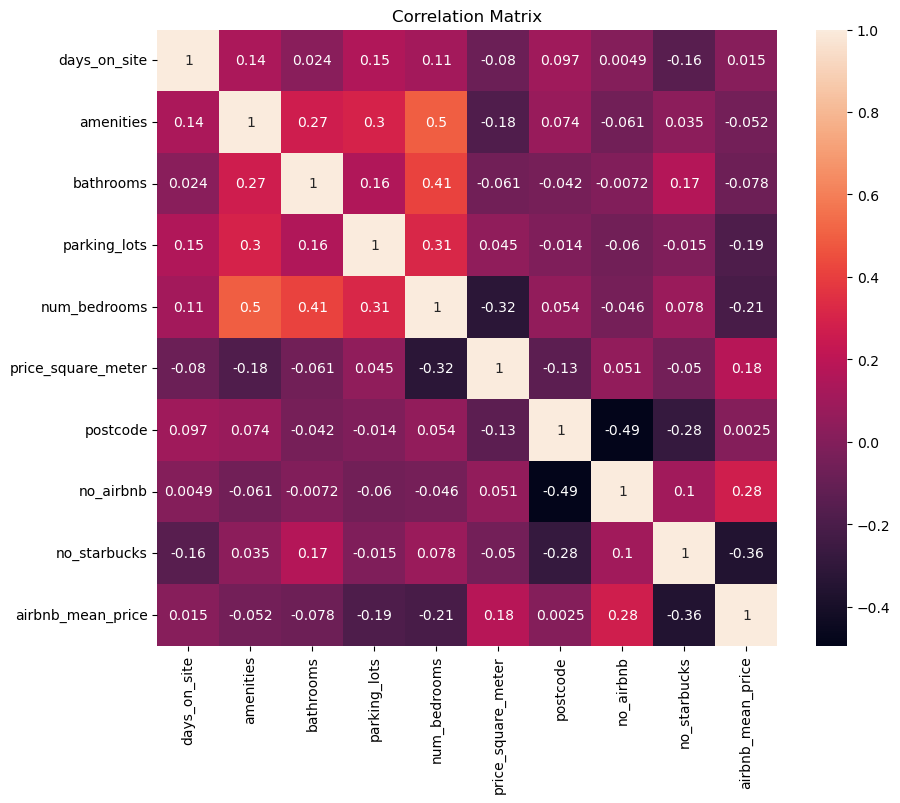

In [158]:
# Calculate correlation matrix
corr_matrix = housing_df.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='rocket')
plt.title('Correlation Matrix')

# Save the figure as a PNG image
plt.savefig('resources/correlation_matrix.png')
plt.show()

From this correlation matrix, we can get a first idea on how correlated every feature is to the price per square meter of properties. The first hypothesis we can extract are that those are:
- Airbnb Mean Price
- Number of Bedrooms
- Amenities
- Location

Nevertheless, this could be due to the nature of the numbers and the data not being standardize and it's something we will be able to evaluate way better further down the road when we have a predictive model.

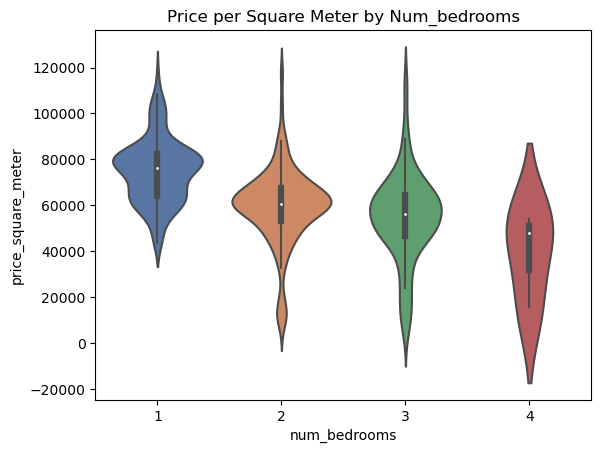

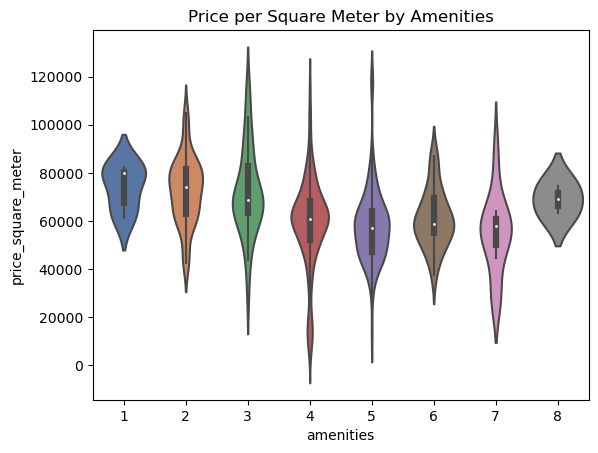

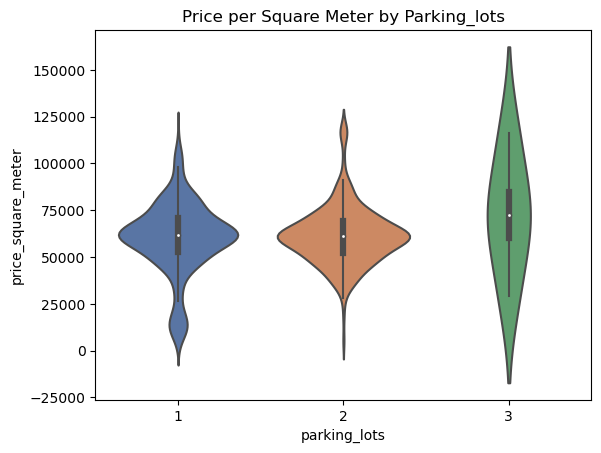

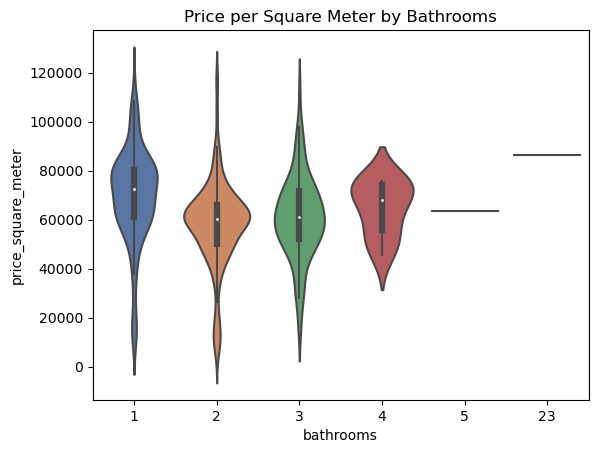

In [79]:
columns_to_plot = ['num_bedrooms', 'amenities','parking_lots','bathrooms']
create_violin_charts(housing_df, columns_to_plot)

Next, let's see the spread of the data on each group

- **Number of Bedrooms**

we see that we get an unusual correlation with this feature, reason being there's probably a drop-down point on the marginal value a square meter of land can be conveyed in regards to the price per square meter.

- **Amenities**

In regards to this feature, we see that the tendency drops down in the middle, to then raise when we get to higher number of amenities. This could also be due to the method we used to replace the NaN values of our dataset and can be evaluated further down the road as one of our possible improvements.

- **Parking Spaces**

As expected, having three parking spaces available is something not common, and we see the correspondent jump on price associated.

- **Number of Bathrooms**
We see a similar tendency with the number of bathrooms, nevertheless one of the main points to gather from this is an abnormal correlation for the group of properties with just one bathroom.

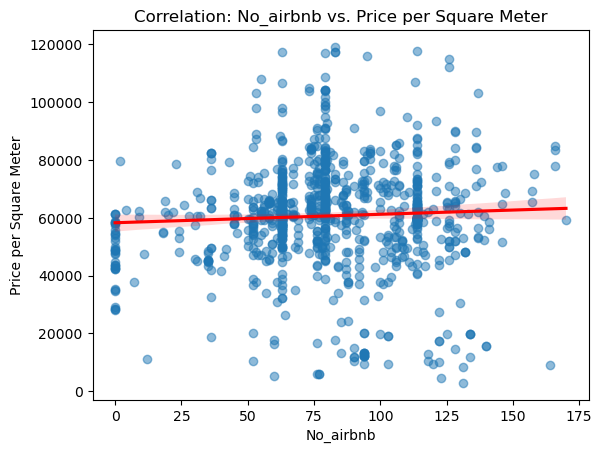

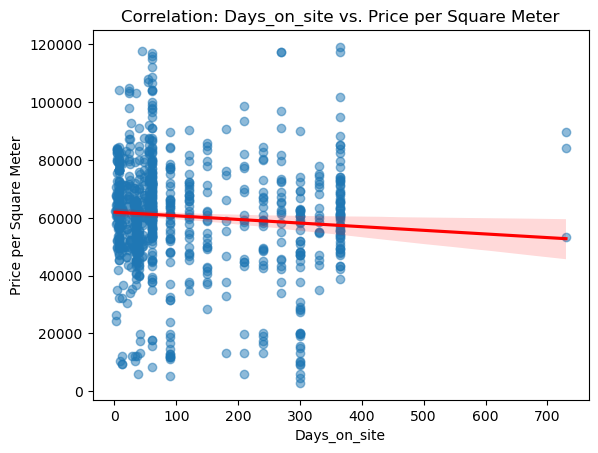

In [82]:
columns_to_analyze = ['no_airbnb','days_on_site']
create_scatter_plots(housing_df, columns_to_analyze)

When Analyzing two of our other important variables we see that the number of Airbnbs nearby the property does correlates to higher property prices. This could be due to two main reasons:
- The properties with more Airbnbs nearby will tend to be on denser population areas.
- Airbnbs tend to be located on touristic sites, where the property value increases.

Finally, we see a correlation between the days on site feature and the price per square meter. Properties with higher days on site will most likely be less desirable and the more days it has on the platform, the most likely it is to correspond to lower prices.

### Análisis Descriptivo

In [16]:
housing_df.describe()

,lat,lon,days_on_site,amenities,bathrooms,parking_lots,num_bedrooms,price_square_meter,postcode
count,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000,950.000000
mean,19.655069,-99.223338,104.950734,4.080813,1.967505,1.334382,2.103774,60578.010169,8847.548421
std,1.245800,0.616146,117.268137,0.917812,0.895361,0.483009,0.627062,18322.092145,10975.733828
min,19.360533,-117.063962,1.000000,1.000000,1.000000,1.000000,1.000000,2932.076453,1619.000000
25%,19.405824,-99.165172,33.250000,4.000000,2.000000,1.000000,2.000000,52315.826333,6700.000000
50%,19.411515,-99.163622,60.000000,4.081349,2.000000,1.000000,2.000000,61232.748260,6700.000000
75%,19.419526,-99.161124,150.000000,4.081349,2.000000,2.000000,2.000000,70078.102952,6760.000000
max,32.528726,-99.128642,730.000000,8.000000,23.000000,3.000000,4.000000,119051.044600,67188.000000


From a general anaylsis of the statistic metrics of our dataset we can gather some insights:
- **Days on site** 
    - The average days on site is 104, any property with a number higher than this will tend to have lower prices and be less desirable. Nevertheless it's also possible that the properties with steeper prices are going to take a little bit more to sell.
    - The standard deviation is 117, quite a high number that will translate to a higher spread, which means the average days on site will be highly influenced by outliers.
    - We can confirm our previous point by looking at our 25%,50% and 75% which are all either below the average or very close. Left skewed distribution.
- **Amenities**
    - Observing the mean against the standard deviation and 25%,50% and 75% we can conclude that most of the properties will have 4 amenities accounted with a few outliers that reach 8.
- **Bathrooms**
    - On this category the main takeaway is the fact that we have at least one outlier of 23 bathrooms that we have to handle
- **Parking lots**
    - We can expect most of the properties to have just one parking spot. Further down the road we could confirm the previous point made about the correlation between price per square meter and airbnb assuming that properties located on dense population zones will also probably have just one parking space.
- ** Price per Square Meter**
    - The average is 60,578 with an standard deviation of 18,322 which we could take into consideration when we evaluate our model metrics.

## Modelado y Predicción

For our predictive model, we will start with the general rule of, the simpler, the better, trying to use a linear regression model which would aid with costs, time and resources. Assuming that it's probably not going to be enough, we will the proceed to try a Random Forest Regressor and a Gradient Booster Regressor.

In [87]:
# Define X and y for your features and target variable
X = housing_encoded.drop('price_square_meter', axis = 1)
y = housing_encoded['price_square_meter']

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Create a scaler object
scaler = StandardScaler()

# Step 4: Feature Scaling with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Model Selection and Training
models = [
    LinearRegression(),
    RandomForestRegressor(),
    XGBRegressor()
]

for model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Model: {model.__class__.__name__}")
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")
    print()

# Step 6: Model Evaluation and Feature Importance
# Assuming RandomForestRegressor is the selected model
best_model = RandomForestRegressor()
best_model.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
})

feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("Feature Importance:")
print(feature_importance)

Model: LinearRegression
MSE: 1.6458955345583422e+30
R-squared: -5.042006813375446e+21

Model: RandomForestRegressor
MSE: 189661473.76006502
R-squared: 0.4189944483993745

Model: XGBRegressor
MSE: 197990960.9280772
R-squared: 0.3934780470414291

Feature Importance:
                                      Feature  Importance
5                                   no_airbnb    0.165789
7                           airbnb_mean_price    0.152879
4                                num_bedrooms    0.134409
0                                days_on_site    0.120852
1                                   amenities    0.099164
6                                no_starbucks    0.065670
3                                parking_lots    0.050183
2                                   bathrooms    0.042547
19                       neighbourhood_others    0.038073
8                   vendor_Buscatuhogarmexico    0.025556
12                      street_Calle Coahuila    0.020045
33                            postcode_

To be able to visualize the importance that each feature represents in our model, after determining which is our best performing model, we are going to get each feature importance and visualize to gather conclusions.

In [143]:
# Step 2: Feature Selection and Determining Optimal Number of Features
X = housing_encoded.drop('price_square_meter', axis=1)
y = housing_encoded['price_square_meter']

estimator = RandomForestRegressor()  # Choose your desired estimator
selector = RFE(estimator, n_features_to_select=None)  # No. of features to select, set to None for automatic selection
X_rfe = selector.fit_transform(X, y)
selected_features = X.columns[selector.support_]
optimal_num_features = len(selected_features)
print(f"Optimal Number of Features: {optimal_num_features}")

# Step 3: Selecting Features and Splitting the Data
X = X[selected_features]
y = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Feature Scaling with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Model Selection and Training with Hyperparameter Tuning
models = [
    {
        'model': RandomForestRegressor(),
        'params': {
            'randomforestregressor__n_estimators': [100, 200, 500],
            'randomforestregressor__max_depth': [None, 5, 10]
        }
    },
    {
        'model': XGBRegressor(),
        'params': {
            'xgbregressor__n_estimators': [100, 200, 500],
            'xgbregressor__max_depth': [3, 5, 7],
            'xgbregressor__learning_rate': [0.01, 0.1, 0.2]
        }
    }
]

best_model = None
best_model_score = float('-inf')

for model in models:
    pipeline = make_pipeline(StandardScaler(), model['model'])
    grid_search = GridSearchCV(pipeline, model['params'], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    y_pred = grid_search.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print(f"Model: {model['model'].__class__.__name__}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"R-squared: {r2}")
    print()

    if r2 > best_model_score:
        best_model = grid_search.best_estimator_
        best_model_score = r2

# Step 6: Model Evaluation and Feature Importance
# Assuming the best model is a RandomForestRegressor
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_model.named_steps[model['model'].__class__.__name__.lower()].feature_importances_
})

feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("Feature Importance:")
print(feature_importance)

Optimal Number of Features: 22
Model: RandomForestRegressor
Best Parameters: {'randomforestregressor__max_depth': None, 'randomforestregressor__n_estimators': 200}
MSE: 163639159.09621397
RMSE: 12792.152246444457
MAE: 9363.816277951644
MAPE: 20.962405745517415
R-squared: 0.4289101429084057

Model: XGBRegressor
Best Parameters: {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 100}
MSE: 161414082.79724658
RMSE: 12704.884210304577
MAE: 9295.459415678011
MAPE: 20.446284891993578
R-squared: 0.43667551222839873

Feature Importance:
                                      Feature  Importance
18                       neighbourhood_others    0.131208
4                                num_bedrooms    0.120526
20                            postcode_6700.0    0.093620
11                      street_Calle Coahuila    0.091449
8                   vendor_Buscatuhogarmexico    0.078514
10                              vendor_others    0.057523
7             

Having determined that the best performing model is a gradient booster, our final step will be to compile the previously encoded columns so we can correctly quantify their importance in the calculation.

In [153]:
# Retrieve feature importance from the best model
importance = best_model.named_steps[model['model'].__class__.__name__.lower()].feature_importances_

# Get the list of vendor columns
vendor_columns = [col for col in selected_features if col.startswith('vendor_')]
# Calculate aggregated importance for the vendor column
vendor_importance = np.sum([importance[i] for i, col in enumerate(selected_features) if col in vendor_columns])

# Get the list of street columns
street_columns = [col for col in selected_features if col.startswith('street_')]
# Calculate aggregated importance for the street column
street_importance = np.sum([importance[i] for i, col in enumerate(selected_features) if col in street_columns])

# Get the list of neighbourhood columns
neighbourhood_columns = [col for col in selected_features if col.startswith('neighbourhood_')]
# Calculate aggregated importance for the neighbourhood column
neighbourhood_importance = np.sum([importance[i] for i, col in enumerate(selected_features) if col in neighbourhood_columns])

# Get the list of postcode columns
postcode_columns = [col for col in selected_features if col.startswith('postcode_')]
# Calculate aggregated importance for the postcode column
postcode_importance = np.sum([importance[i] for i, col in enumerate(selected_features) if col in postcode_columns])

# Calculate importance for the remaining features
remaining_importance = np.sum([importance[i] for i, col in enumerate(selected_features) if col not in vendor_columns and col not in street_columns and col not in neighbourhood_columns and col not in postcode_columns])

# Calculate importance for each individual feature
individual_importance = [importance[i] for i, col in enumerate(selected_features) if col not in vendor_columns and col not in street_columns and col not in neighbourhood_columns and col not in postcode_columns]
individual_features = [col for col in selected_features if col not in vendor_columns and col not in street_columns and col not in neighbourhood_columns and col not in postcode_columns]

# Create a new dataframe for feature importance as a whole
feature_importance_whole = pd.DataFrame({
    'Feature': ['vendor', 'street', 'neighbourhood', 'postcode'] + individual_features,
    'Importance': [vendor_importance, street_importance, neighbourhood_importance, postcode_importance] + individual_importance
})

# Print the feature importance as a whole for vendor, street, neighbourhood, postcode, and remaining features
feature_importance_whole


,Feature,Importance
0,vendor,0.184865
1,street,0.146457
2,neighbourhood,0.160370
3,postcode,0.123153
4,days_on_site,0.037837
5,amenities,0.040142
6,bathrooms,0.019540
7,parking_lots,0.043457
8,num_bedrooms,0.127854
9,no_airbnb,0.043599


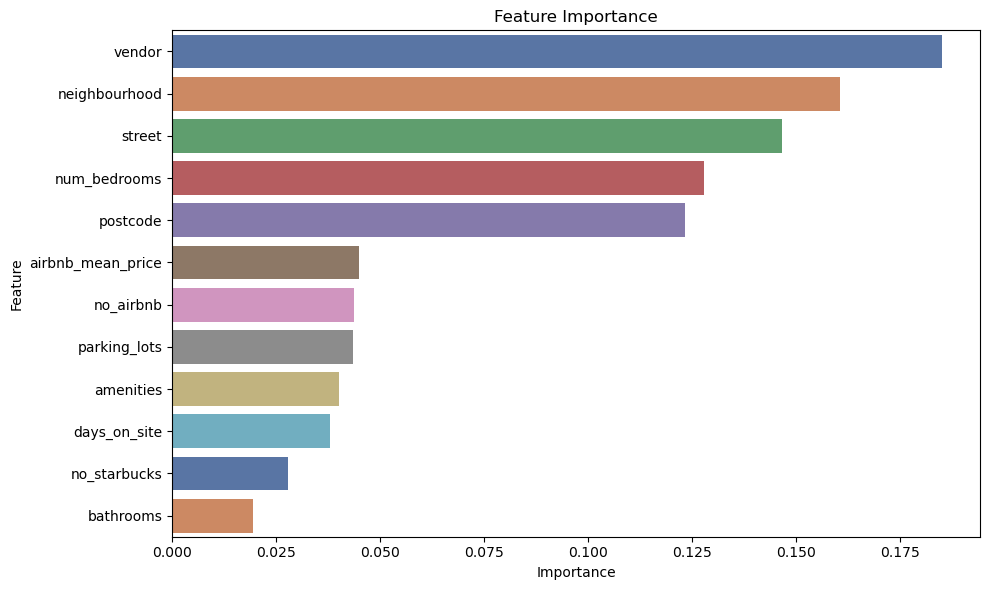

In [156]:
# Sort the feature importances in descending order
feature_importance_whole = feature_importance_whole.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_whole, palette='deep')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## Resultados y Conclusiones

From our final chart we can see that the most important features to determine the price per square meter of a property are:
- **Vendor** : We should take this with a grain of salt given that this is not an inherent variable of the property itself. Nevertheless is safe to assume that the vendor will play a significant role on the average value of the property. This will also helps us determine tendencies and how every vendor plays with the market price.


- **Neighbourhood** : I will consider this to be our main feature to consider, the location of the property will play the most important role to determine the price per square meter of the property due to multiple factors, some of them previously mentioned, like how touristic the area is or how densely populated it is. All of them increasing the desirability associated to that area.


- **Street** : This further confirms the hypothesis stated before, but it would be useful to evaluate the colinearity of both variables down the road to see if we can gain some predictive power in our model.


- **Number of Bedrooms** : The correlation this feature plays is interesting to analyze, the number of bedrooms will increase the square meters built dividing the price among more square meters. It would be also interesting to deepen the correlation and determine if there is any point of marginal return where the increase of bedrooms or square meters starts to diminish.


- **Airbnb Average Price per Night** : As our previous hypothesis stated, gentrification will play an important role in evaluating real estate market tendencies and adding this feature proved useful in order to increase the predictive power of our model.

## Áreas de Mejora

One of the most obvious ways to increase our predictive power as well as gather better conclusions on futher iterations would be to scrape for more data.

For example, below, as an approach to optimize our model we see a script that could be use to scrape the website source of our original dataset to add more informationa bout amenities nearby the property and enhance the contribution this variable plays by also dividing it by type, transportation, leisure, schools and so on.

In [38]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the search page
url = "https://inmuebles.metroscubicos.com/ciudad-de-mexico#D[A:ciudad%20de%20mexico]"

# Send a GET request to the URL
response = requests.get(url)

# Create a BeautifulSoup object with the response text
soup = BeautifulSoup(response.text, "html.parser")

# Find all the property posts on the page
property_posts = soup.find_all("div", class_="andes-card andes-card--flat andes-card--default ui-search-result shops__cardStyles ui-search-result--res andes-card--padding-default andes-card--animated")

data = []

# Iterate over each property post
for post in property_posts:
    # Extract the URL of the individual post
    post_link = post.find("a", class_="ui-search-link")["href"]
    
    # Send a GET request to the individual post URL
    post_response = requests.get(post_link)
    
    # Create a BeautifulSoup object with the post response text
    post_soup = BeautifulSoup(post_response.content, "html.parser")
    
    # Find the div with id 'points_of_interest'
    points_of_interest_div = post_soup.find('div', {'id': 'points_of_interest'})

    # Check if points_of_interest_div is not None
    if points_of_interest_div:
        # Find the title of the section
        section_title = points_of_interest_div.find('h2').text.strip()

        # Find all the subsections within the section
        subsections = points_of_interest_div.find_all('div', {'class': 'ui-vip-poi__subsection'})

        # Iterate over each subsection
        for subsection in subsections:
            # Find the title of the subsection
            subsection_title = subsection.find('span', {'class': 'ui-vip-poi__subsection-title'}).text.strip()

            # Find all the items within the subsection
            items = subsection.find_all('div', {'class': 'ui-vip-poi__item'})

            # Iterate over each item
            for item in items:
                # Find the item title
                item_title = item.find('span', {'class': 'ui-pdp-family--REGULAR'}).text.strip()

                # Find the item subtitle
                item_subtitle = item.find('span', {'class': 'ui-pdp-color--GRAY'}).text.strip()

                # Find the price and highlighted specifications
                price_div = post_soup.find('div', {'id': 'price'})
                highlighted_specs_div = post_soup.find('div', {'id': 'highlighted_specs_res'})

                # Extract the price
                price = price_div.find('span', class_='andes-money-amount__fraction').text.strip() if price_div else 'N/A'

                # Extract the highlighted specifications
                specs = {}
                if highlighted_specs_div:
                    spec_items = highlighted_specs_div.find_all('div', class_='ui-pdp-highlighted-specs-res__icon-label')
                    for item in spec_items:
                        icon = item.find('svg')['class'][1].replace('ui-pdp-icon--', '')
                        label = item.find('span', class_='ui-pdp-label').text.strip()
                        specs[icon] = label

                # Append the data to the list
                data.append([section_title, subsection_title, item_title, item_subtitle, price, specs.get('scale-up', 'N/A'), specs.get('bed', 'N/A'), specs.get('bathroom', 'N/A')])

# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=['Section', 'Subsection', 'Item Title', 'Item Subtitle', 'Price', 'Scale Up', 'Beds', 'Bathrooms'])

# Print the DataFrame
df

,Section,Subsection,Item Title,Item Subtitle,Price,Scale Up,Beds,Bathrooms
0,Información de la zona,Paraderos,Santiago,12 mins - 920 metros,"4,200,000",N/A,N/A,N/A
1,Información de la zona,Paraderos,Taxis,"13 mins - 1,019 metros","4,200,000",N/A,N/A,N/A
2,Información de la zona,Paraderos,Súper ocho,"13 mins - 1,036 metros","4,200,000",N/A,N/A,N/A
3,Información de la zona,Paraderos,Centro Comercial Santa Cruz,"15 mins - 1,174 metros","4,200,000",N/A,N/A,N/A
4,Información de la zona,Paraderos,El retiro,"22 mins - 1,714 metros","4,200,000",N/A,N/A,N/A
...,...,...,...,...,...,...,...,...
248,Información de la zona,Paraderos,Glorieta de Colón,2 mins - 122 metros,"19,700",90 m² totales,2 recámaras,2 baños
249,Información de la zona,Paraderos,Glorieta de Colón,2 mins - 163 metros,"19,700",90 m² totales,2 recámaras,2 baños
250,Información de la zona,Paraderos,Glorieta de Colón,3 mins - 200 metros,"19,700",90 m² totales,2 recámaras,2 baños
251,Información de la zona,Paraderos,Glorieta de Colón,3 mins - 242 metros,"19,700",90 m² totales,2 recámaras,2 baños
